In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
import torchvision.utils as vutils

import os
import json
import numpy as np
import csv
import pandas as pd
import math
import numpy as np
import glob
import tqdm
import sys
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from tqdm import tqdm
import sklearn
from sklearn.metrics import accuracy_score

import seaborn as sns
sns.set_theme(style="ticks")

import torchvision
from torchvision.io import read_image

# from sdtw_cuda_loss import SoftDTW

In [3]:
# %load_ext tensorboard
# from torch.utils.tensorboard import SummaryWriter

In [4]:
device = torch.device('cuda:1') #  if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=1)

In [5]:
# target_folder = './extracted/mwd/nopims/'
target_folder = '/home/sharifullina/thesis/TIME/extracted/mwd/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/nopims/'

### Выгрузим датасет Volve и преобразуем данные

In [7]:
wells = os.listdir(target_folder)
required_params_plus = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA', 'WELL']
required_params = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA']

logs = [json.load(open(os.path.join(target_folder, wells[i]), 'r')) for i in range(len(wells))]

In [8]:
# X_all - Dataframe with all logging while drilling data concatenated

dataset_all = [pd.DataFrame(logs[i]['data'], columns=[x['name'] for x in logs[i]['curves']]) for i in range(len(logs))]
for i in range(len(dataset_all)):
    dataset_all[i]['WELL'] = wells[i]

dataset = []
for df in dataset_all:
    dataset.append(df[required_params_plus])
    
X_all = dataset[0]
for i in range(1, len(dataset)):
    X_all = pd.concat([X_all, dataset[i]], ignore_index = True)
X_all = X_all.ffill().bfill()

# X_list is a list containing a data for all wells splitted to windows with size 256

X_list = []
for i in range(0, len(X_all) - 256, 10):
    X_list.append(X_all[i : 256 + i])

    
# X_list_minus is X_list but without the WELL column
    
X_list_minus = []
for x in X_list:
    X_list_minus.append(x.loc[:, x.columns != 'WELL'])

X_verif_list = X_list_minus
    
# X is an array with the shape = (5901, 256, 5)
    
X = []
for i in X_list_minus:
    X.append(i.values)

X = np.dstack(X)
X = np.rollaxis(X, -1)

# map_well_to_label is dictionary to help to rename wells from 'well_N' to N
map_well_to_label = {w:i for i, w in enumerate(wells)}

# label = well's number
y = np.array([map_well_to_label[df['WELL'].iloc[0]] for df in X_list])


### Импортируем verificator, regulator

In [9]:
from dataset import *
from model import * # GAN model
from inceptiontime.src.models.inception import InceptionModel # Verificator
# Regulator
from time_series_metrics.ssim_loss import SSIM_1d_conv
# from time_series_metrics.tsfresh_metrics import tsfresh_metrics
from time_series_metrics.tsfresh_loss import Mean_similarity_loss, Root_mean_square_similarity_loss, Coisine_between_angles_loss, Pearson_corr_funct_loss, Eucledian_distance_loss


### Загрузим датасет

In [10]:
torch_dataset = DataSet(X, y, sparse_rate=1)
all_loader = DataLoader(torch_dataset, batch_size=64, shuffle=True)

In [11]:
train_n = 5310
train_set, val_set = torch.utils.data.random_split(torch_dataset, [train_n, len(torch_dataset) - train_n])

In [12]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)

### создадим датасет для верификатора

In [13]:
# соеденим все логи скважин в один большой pandas.DaraFrame
dataset_all = [pd.DataFrame(logs[i]['data'], columns=[x['name'] for x in logs[i]['curves']]) for i in range(len(logs))]
dataset = []
for df in dataset_all:
    dataset.append(df[required_params])
X_all = dataset[0]
for i in range(1, len(dataset)):
    X_all = pd.concat([X_all, dataset[i]], ignore_index = True)
X_all = X_all.ffill().bfill()

In [14]:
similar_wells = []

for i in range(0, 18400, 20):
    similar_wells.append(X_all[i : 256 + i])
# преобразуем лист в массив с размерностью [20, 256, 5]; 20 - количество скважин, 256 - размерность окна, 
#                                                   5 - количество столбцов = len(required_params)
similar_wells = np.dstack(similar_wells)
similar_wells = np.rollaxis(similar_wells, -1)
similar_wells.shape

(920, 256, 5)

In [15]:
different_wells = []

for i in range(0, 256 * 230, 256):
    different_wells.append(X_all[i : 256 + i])
    different_wells.append(X_all[i : 256 + i] + np.random.normal(X_all[i : 256 + i].mean(),\
                                                                 X_all[i : 256 + i].std(), [256, 5]))
    different_wells.append(X_all[i : 256 + i] + np.random.normal(X_all[i : 256 + i].mean(), \
                                                                 X_all[i : 256 + i].std(), [256, 5]))
    different_wells.append(X_all[i : 256 + i] + np.random.normal(X_all[i : 256 + i].mean(),\
                                                                 X_all[i : 256 + i].std(), [256, 5]))
    
different_wells = np.dstack(different_wells)
different_wells = np.rollaxis(different_wells, -1)


In [16]:
needed = []
for i in range(different_wells.shape[0]):
    needed.append([different_wells[i - 1], different_wells[i], 1])
    needed.append([similar_wells[i - 1], similar_wells[i], 0])

In [17]:
# with open('some.csv', 'w') as f:
#     writer = csv.writer(f)
#     writer.writerow(['time1', 'time2', 'relationshion'])
#     writer.writerows(needed)

In [17]:
# df = pd.read_csv('some.csv')
# df = df.sample(frac=1)
# df.head()

In [17]:
from torch.utils.data import Dataset

class Verification(Dataset):
    def __init__(self, needed, feature_scales_simil={}, feature_scales_diff={}):
        
        self.needed = needed
        self.feature_scales_simil = feature_scales_simil
        self.feature_scales_diff = feature_scales_diff
        
    def __getitem__(self, index):

        time1 = self.needed[index][0]
        time2 = self.needed[index][1]
        relation = self.needed[index][2]
        
        self.time1 = torch.tensor(time1).to(torch.float32)
        self.time2 = torch.tensor(time2).to(torch.float32)
        self.relation = torch.tensor(relation).to(torch.float32)
        
        # time1
        for f in range(self.time1.shape[1]):
            self.time1[:, f] = self.time1[:, f] - self.time1[:, f].mean()
            
        for f in range(self.time1.shape[1]):
            if f not in self.feature_scales_simil:
                std = self.time1[:, f].std()
                self.feature_scales_simil[f] = std
            self.time1[:, f] = self.time1[:, f] / self.feature_scales_simil[f]
            
        # time2
        for f in range(self.time2.shape[1]):
            self.time2[:, f] = self.time2[:, f] - self.time2[:, f].mean()
            
        for f in range(self.time2.shape[1]):
            if f not in self.feature_scales_diff:
                std = self.time2[:, f].std()
                self.feature_scales_diff[f] = std
            self.time2[:, f] = self.time2[:, f] / self.feature_scales_diff[f]
            
        self.time1 = self.time1.transpose(0, 1)
        self.time2 = self.time2.transpose(0, 1)

        return self.time1, self.time2, self.relation

    def __len__(self):
        return len(self.needed)
    

In [18]:
verif_dataset = Verification(needed)
verif_loader = DataLoader(verif_dataset, batch_size=64, shuffle=True)

In [20]:
# test
for time1, time2, label in verif_loader:
    print(time1.shape)
    print(time2.shape)
    print(label.shape)
    break

torch.Size([64, 5, 256])
torch.Size([64, 5, 256])
torch.Size([64])


### Train verification model

In [21]:
model_verification = InceptionModel(num_blocks=2, in_channels=len(required_params), 
                       out_channels=30,
                       bottleneck_channels=12, kernel_sizes=15,
                       use_residuals=True, 
                       num_pred_classes=len(wells)).to(device)

optimizer_verification = torch.optim.Adam(model_verification.parameters(), lr=1e-3)

In [23]:
class VerificationLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(VerificationLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        pos = (1-label) * torch.pow(euclidean_distance, 2)
        neg = (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        loss_contrastive = torch.mean( pos + neg )
        return loss_contrastive

criterion_verification = VerificationLoss()

Epoch [0/100] Loss V: 1.1087
Epoch [10/100] Loss V: 0.3307
Epoch [20/100] Loss V: 0.4070
Epoch [30/100] Loss V: 0.1218
Epoch [40/100] Loss V: 0.1344
Epoch [50/100] Loss V: 0.1352
Epoch [60/100] Loss V: 0.2814
Epoch [70/100] Loss V: 0.2896
Epoch [80/100] Loss V: 0.1990
Epoch [90/100] Loss V: 0.1678


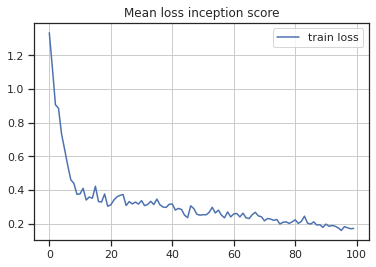

In [24]:
best_train_acc = 0
train_loss = []
train_acc = []
num_epochs = 100
patience_counter = 0
best_state_dict = None

for epoch in range(num_epochs):
    model_verification.train();
    epoch_train_loss = []
    all_preds = []
    all_y = []
    for time1, time2, label in verif_loader:
        time1 = time1.to(device)
        time2 = time2.to(device)
        label = label.to(device)
        optimizer_verification.zero_grad()
        encoded_1 = model_verification(time1) 
        encoded_2 = model_verification(time2)
        loss = criterion_verification(encoded_1, encoded_2, label)
        epoch_train_loss.append(loss.item())
        loss.backward()
        optimizer_verification.step()
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}] Loss V: {loss.item():.4f}")
    train_loss.append(np.mean(epoch_train_loss))


plt.plot(train_loss, label = 'train loss')
plt.legend()
plt.grid()
plt.title('Mean loss inception score')
plt.show()

torch.save({
    'model_state_dict': model_verification.state_dict(),
}, 
    'trained_models/model_verification.pt'
)

In [26]:
model_verification = InceptionModel(num_blocks=2, in_channels=len(required_params), 
                                    out_channels=30,
                                    bottleneck_channels=12, kernel_sizes=15,
                                    use_residuals=True, 
                                    num_pred_classes=len(wells)).to(device)
checkpoint = torch.load('trained_models/model_verification.pt')
model_verification.load_state_dict(checkpoint['model_state_dict'])
# model_verification.eval()

<All keys matched successfully>

### Training models

In [27]:
# GANs hyperparamters
lr = 3e-4
batch_size = 128
num_epochs = 100
n_noise = 256
n_critic = 1
fixed_noise = torch.randn((batch_size, len(required_params), 256)).to(device)

In [28]:
disc_ms = Discriminator().to(device)
gen_ms = Generator().to(device)

disc_rms = Discriminator().to(device)
gen_rms = Generator().to(device)

disc_cba = Discriminator().to(device)
gen_cba = Generator().to(device)

disc_pcf = Discriminator().to(device)
gen_pcf = Generator().to(device)

disc_ed = Discriminator().to(device)
gen_ed = Generator().to(device)

disc_ssim = Discriminator().to(device)
gen_ssim = Generator().to(device)

criterion_gan_ms = nn.BCELoss()
criterion_gan_rms = nn.BCELoss()
criterion_gan_cba = nn.BCELoss()
criterion_gan_pcf = nn.BCELoss()
criterion_gan_ed = nn.BCELoss()
criterion_gan_ssim = nn.BCELoss()

D_opt_ms = torch.optim.Adam(disc_ms.parameters(), lr = lr)
G_opt_ms = torch.optim.Adam(gen_ms.parameters(), lr = lr)

D_opt_rms = torch.optim.Adam(disc_rms.parameters(), lr = lr)
G_opt_rms = torch.optim.Adam(gen_rms.parameters(), lr = lr)

D_opt_cba = torch.optim.Adam(disc_cba.parameters(), lr = lr)
G_opt_cba = torch.optim.Adam(gen_cba.parameters(), lr = lr)

D_opt_pcf = torch.optim.Adam(disc_pcf.parameters(), lr = lr)
G_opt_pcf = torch.optim.Adam(gen_pcf.parameters(), lr = lr)

D_opt_ed = torch.optim.Adam(disc_ed.parameters(), lr = lr)
G_opt_ed = torch.optim.Adam(gen_ed.parameters(), lr = lr)

D_opt_ssim = torch.optim.Adam(disc_ssim.parameters(), lr = lr)
G_opt_ssim = torch.optim.Adam(gen_ssim.parameters(), lr = lr)

In [29]:
# print('Discriminator paramteres:', sum(p.numel() for p in disc_mean_similarity.parameters() if p.requires_grad))
# print('Generator paramteres:', sum(p.numel() for p in gen_mean_similarity.parameters() if p.requires_grad))

In [30]:
# writer_fake = SummaryWriter(f"/home/sharifullina/thesis/logs_cGAN_time_series/fake")
# writer_real = SummaryWriter(f"/home/sharifullina/thesis/logs_cGAN_time_series/real")

### training the model

In [31]:
def train(loader, 
          gen, 
          disc, 
          criterion_gan, 
          G_opt, 
          D_opt, 
          model_verification, 
          criterion_verification, 
          criterion_regulator,
          save_PATH, 
          lr, batch_size, num_epochs, n_noise, n_critic):
    
    de_ident_rate = 0
    simil_index = 0

    G_losses = []
    D_losses = []
    R_losses = []
    V_losses = []
    V_losses2 = []
    verificator_labels = []
    verificator_preds = []

    torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        for idx, data_all in enumerate(loader):
            # data preprocessing
            step = 0
            real_data, y = data_all
            real_data, y = real_data.to(device), y.to(device)
            batch_size = real_data.size(0)

            # DISCRIMINATOR TRAINING == maximize D(real_data) + (1 - D(G(noise)))
            gen.eval()
            disc.train()
            D_opt.zero_grad()

            fake = gen(real_data)
            disc_real = disc(real_data)        
            D_loss_1 = criterion_gan(disc_real, torch.ones_like(disc_real))
            disc_fake = disc(fake)
            D_loss_2 = criterion_gan(disc_fake, torch.zeros_like(disc_fake))
            
            # verificator loss
            model_verification.eval()
            embeding_fake = model_verification(fake)
            embeding_real = model_verification(real_data)
            label = torch.ones(batch_size).to(device)
            loss_verif = criterion_verification(embeding_real, embeding_fake, label)
            V_losses.append(loss_verif.item())
            
            # de-identification rate
            threshold = torch.tensor([0.1]).to(device)
            de_iden_rate_now = (abs(embeding_real - embeding_fake) > threshold).float().mean()
            
            if de_ident_rate < de_iden_rate_now:
                de_ident_rate = de_iden_rate_now
                
            
            # similarity loss
            if criterion_regulator != Eucledian_distance_loss:
                loss_regul = criterion_regulator()(real_data, fake)
            else:
                loss_regul = criterion_regulator()(real_data, fake) / 1000
            R_losses.append(loss_regul.item())
            
            D_loss = (D_loss_1 + D_loss_2) / 2 + loss_verif.detach() + loss_regul.detach()
            D_losses.append(D_loss.item())
            D_loss.backward() # retain_graph = True
            D_opt.step()
            
            # GENERATOR TRAINING == maximize D(G(noise))
            gen.train()
            disc.eval()
            G_opt.zero_grad()

            fake = gen(real_data)
            output = disc(fake)
            G_loss = criterion_gan(output, torch.ones_like(output))
            G_losses.append(G_loss.item())
            G_loss.backward() 
            G_opt.step()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {idx}/{len(loader)} Loss D: {D_loss.item():.4f}, Loss G: {G_loss.item():.4f}, Loss V: {loss_verif.item():.4f}, Loss R: {loss_regul.item():.4f}")


            step += 1
                    
    torch.save({
        'gen_state_dict': gen.state_dict(),
        'disc_state_dict': disc.state_dict(),
        'de_ident_rate': de_ident_rate,
        'str_simil': 1 - loss_regul.item()
    }, save_PATH)
    
    return G_losses, D_losses, R_losses, V_losses, V_losses2

---

### models training

In [32]:
losses_ms = train(loader = train_loader, 
                  gen = gen_ms, 
                  disc = disc_ms, 
                  criterion_gan = criterion_gan_ms, 
                  G_opt = G_opt_ms, 
                  D_opt = D_opt_ms, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Mean_similarity_loss,
                  save_PATH = 'trained_models/gan_ms.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/100] Batch 82/83 Loss D: 0.9688, Loss G: 0.4439, Loss V: 0.6202, Loss R: 0.2564
Epoch [10/100] Batch 82/83 Loss D: 1.6895, Loss G: 0.2703, Loss V: 1.4767, Loss R: 0.2120
Epoch [20/100] Batch 82/83 Loss D: 0.4680, Loss G: 0.0042, Loss V: 0.2617, Loss R: 0.2059
Epoch [30/100] Batch 82/83 Loss D: 0.4430, Loss G: 0.0022, Loss V: 0.2201, Loss R: 0.2227
Epoch [40/100] Batch 82/83 Loss D: 0.2309, Loss G: 0.0021, Loss V: 0.0243, Loss R: 0.2064
Epoch [50/100] Batch 82/83 Loss D: 0.2155, Loss G: 0.0007, Loss V: 0.0000, Loss R: 0.2155
Epoch [60/100] Batch 82/83 Loss D: 0.2181, Loss G: 0.0007, Loss V: 0.0000, Loss R: 0.2180
Epoch [70/100] Batch 82/83 Loss D: 0.2239, Loss G: 0.0007, Loss V: 0.0000, Loss R: 0.2239
Epoch [80/100] Batch 82/83 Loss D: 0.2215, Loss G: 0.0003, Loss V: 0.0000, Loss R: 0.2214
Epoch [90/100] Batch 82/83 Loss D: 0.2152, Loss G: 0.0005, Loss V: 0.0000, Loss R: 0.2152


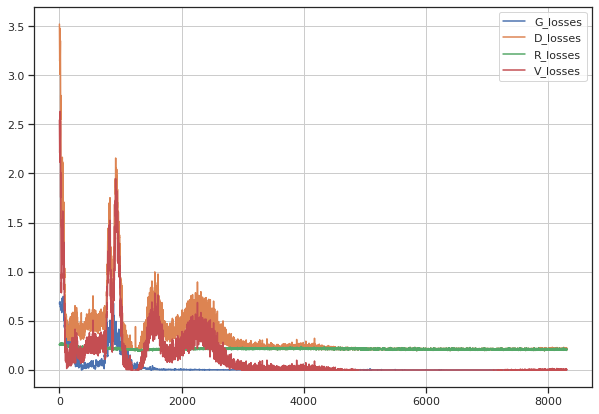

In [33]:
plt.figure(figsize=(10, 7))
plt.plot(losses_ms[0], label = 'G_losses')
plt.plot(losses_ms[1], label = 'D_losses')
plt.plot(losses_ms[2], label = 'R_losses')
plt.plot(losses_ms[3], label = 'V_losses')
plt.legend()
plt.grid()
plt.show()

In [35]:
gen_ms = Generator().to(device)
disc_ms = Discriminator().to(device)

checkpoint_ms = torch.load('trained_models/gan_ms.pt')

gen_ms.load_state_dict(checkpoint_ms['gen_state_dict'])
disc_ms.load_state_dict(checkpoint_ms['disc_state_dict'])
de_ident_rate_ms = checkpoint_ms['de_ident_rate']
str_simil_ms = checkpoint_ms['str_simil']
str_simil_ms
# gen_ms.eval()

0.7846010327339172

### root_mean_square

In [36]:
losses_rms = train(loader = train_loader, 
                  gen = gen_rms, 
                  disc = disc_rms, 
                  criterion_gan = criterion_gan_rms, 
                  G_opt = G_opt_rms, 
                  D_opt = D_opt_rms, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Root_mean_square_similarity_loss,
                  save_PATH = 'trained_models/gan_rms.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/100] Batch 82/83 Loss D: 1.3353, Loss G: 0.3486, Loss V: 0.8297, Loss R: 0.4049
Epoch [10/100] Batch 82/83 Loss D: 0.3500, Loss G: 0.2479, Loss V: 0.0000, Loss R: 0.3489
Epoch [20/100] Batch 82/83 Loss D: 0.3698, Loss G: 0.0373, Loss V: 0.0000, Loss R: 0.3694
Epoch [30/100] Batch 82/83 Loss D: 0.3633, Loss G: 0.0054, Loss V: 0.0000, Loss R: 0.3629
Epoch [40/100] Batch 82/83 Loss D: 0.3614, Loss G: 0.0028, Loss V: 0.0000, Loss R: 0.3613
Epoch [50/100] Batch 82/83 Loss D: 0.3504, Loss G: 0.0003, Loss V: 0.0000, Loss R: 0.3503
Epoch [60/100] Batch 82/83 Loss D: 0.3595, Loss G: 0.0004, Loss V: 0.0000, Loss R: 0.3595
Epoch [70/100] Batch 82/83 Loss D: 0.3495, Loss G: 0.0001, Loss V: 0.0000, Loss R: 0.3495
Epoch [80/100] Batch 82/83 Loss D: 0.3514, Loss G: 0.0001, Loss V: 0.0000, Loss R: 0.3514
Epoch [90/100] Batch 82/83 Loss D: 0.3529, Loss G: 0.0001, Loss V: 0.0000, Loss R: 0.3529


In [37]:
gen_rms = Generator().to(device)
disc_rms = Discriminator().to(device)

checkpoint_rms = torch.load('trained_models/gan_rms.pt')

gen_rms.load_state_dict(checkpoint_rms['gen_state_dict'])
disc_rms.load_state_dict(checkpoint_rms['disc_state_dict'])
de_ident_rate_rms = checkpoint_rms['de_ident_rate']
str_simil_rms = checkpoint_rms['str_simil']

# gen_rms.eval()

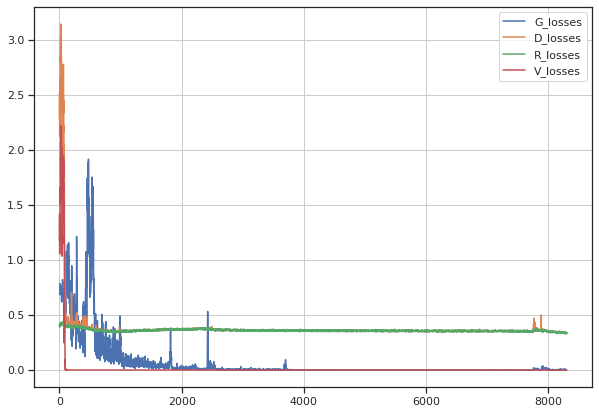

In [38]:
plt.figure(figsize=(10, 7))
plt.plot(losses_rms[0], label = 'G_losses')
plt.plot(losses_rms[1], label = 'D_losses')
plt.plot(losses_rms[2], label = 'R_losses')
plt.plot(losses_rms[3], label = 'V_losses')
plt.legend()
plt.grid()
plt.show()

### coisine_between_angles

In [39]:
losses_cba = train(loader = train_loader, 
                  gen = gen_cba, 
                  disc = disc_cba, 
                  criterion_gan = criterion_gan_cba, 
                  G_opt = G_opt_cba, 
                  D_opt = D_opt_cba, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Coisine_between_angles_loss,
                  save_PATH = 'trained_models/gan_cba.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/100] Batch 82/83 Loss D: 0.2466, Loss G: 0.6455, Loss V: 0.1700, Loss R: -0.0136
Epoch [10/100] Batch 82/83 Loss D: 0.2500, Loss G: 0.0253, Loss V: 0.2487, Loss R: 0.0007
Epoch [20/100] Batch 82/83 Loss D: 0.0034, Loss G: 0.0221, Loss V: 0.0000, Loss R: 0.0032
Epoch [30/100] Batch 82/83 Loss D: 0.0013, Loss G: 0.0111, Loss V: 0.0000, Loss R: 0.0012
Epoch [40/100] Batch 82/83 Loss D: 0.0017, Loss G: 0.0067, Loss V: 0.0000, Loss R: 0.0016
Epoch [50/100] Batch 82/83 Loss D: 0.0008, Loss G: 0.0042, Loss V: 0.0000, Loss R: 0.0007
Epoch [60/100] Batch 82/83 Loss D: 0.0326, Loss G: 0.0027, Loss V: 0.0309, Loss R: 0.0016
Epoch [70/100] Batch 82/83 Loss D: 0.0039, Loss G: 0.0019, Loss V: 0.0022, Loss R: 0.0017
Epoch [80/100] Batch 82/83 Loss D: -0.0007, Loss G: 0.0016, Loss V: 0.0000, Loss R: -0.0007
Epoch [90/100] Batch 82/83 Loss D: -0.0030, Loss G: 0.0188, Loss V: 0.0000, Loss R: -0.0033


In [40]:
gen_cba = Generator().to(device)
disc_cba = Discriminator().to(device)

checkpoint_cba = torch.load('trained_models/gan_cba.pt')

gen_cba.load_state_dict(checkpoint_cba['gen_state_dict'])
disc_cba.load_state_dict(checkpoint_cba['disc_state_dict'])
de_ident_rate_cba = checkpoint_cba['de_ident_rate']
str_simil_cba = checkpoint_cba['str_simil']

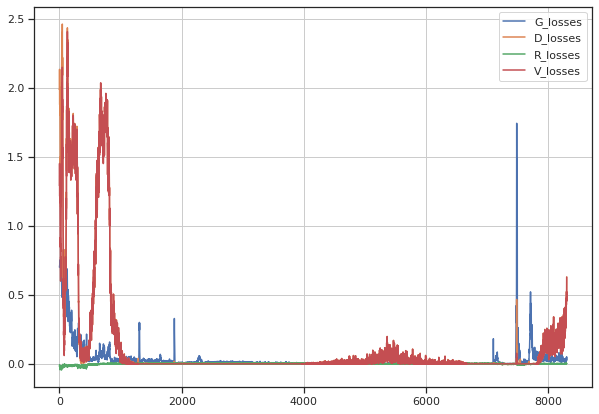

In [41]:
plt.figure(figsize=(10, 7))
plt.plot(losses_cba[0], label = 'G_losses')
plt.plot(losses_cba[1], label = 'D_losses')
plt.plot(losses_cba[2], label = 'R_losses')
plt.plot(losses_cba[3], label = 'V_losses')
plt.legend()
plt.grid()
plt.show()

### pearson_corr_funct

In [42]:
losses_pcf = train(loader = train_loader, 
                  gen = gen_pcf, 
                  disc = disc_pcf, 
                  criterion_gan = criterion_gan_pcf, 
                  G_opt = G_opt_pcf, 
                  D_opt = D_opt_pcf, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Pearson_corr_funct_loss,
                  save_PATH = 'trained_models/gan_pcf.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/100] Batch 82/83 Loss D: 0.7256, Loss G: 0.3763, Loss V: 0.5717, Loss R: 0.0044
Epoch [10/100] Batch 82/83 Loss D: 0.0124, Loss G: 0.1506, Loss V: 0.0026, Loss R: 0.0084
Epoch [20/100] Batch 82/83 Loss D: 0.0275, Loss G: 0.0242, Loss V: 0.0085, Loss R: 0.0186
Epoch [30/100] Batch 82/83 Loss D: 1.8048, Loss G: 0.0035, Loss V: 1.7945, Loss R: 0.0100
Epoch [40/100] Batch 82/83 Loss D: 0.9315, Loss G: 0.0029, Loss V: 0.9265, Loss R: 0.0049
Epoch [50/100] Batch 82/83 Loss D: 0.3818, Loss G: 0.0116, Loss V: 0.3765, Loss R: 0.0053
Epoch [60/100] Batch 82/83 Loss D: 0.0711, Loss G: 0.0030, Loss V: 0.0671, Loss R: 0.0040
Epoch [70/100] Batch 82/83 Loss D: -0.0001, Loss G: 0.0037, Loss V: 0.0000, Loss R: -0.0001
Epoch [80/100] Batch 82/83 Loss D: 0.0019, Loss G: 0.0012, Loss V: 0.0019, Loss R: 0.0000
Epoch [90/100] Batch 82/83 Loss D: 0.0154, Loss G: 0.0005, Loss V: 0.0123, Loss R: 0.0030


In [43]:
gen_pcf = Generator().to(device)
disc_pcf = Discriminator().to(device)

checkpoint_pcf = torch.load('trained_models/gan_pcf.pt')

gen_pcf.load_state_dict(checkpoint_pcf['gen_state_dict'])
disc_pcf.load_state_dict(checkpoint_pcf['disc_state_dict'])
de_ident_rate_pcf = checkpoint_pcf['de_ident_rate']
str_simil_pcf = checkpoint_pcf['str_simil']

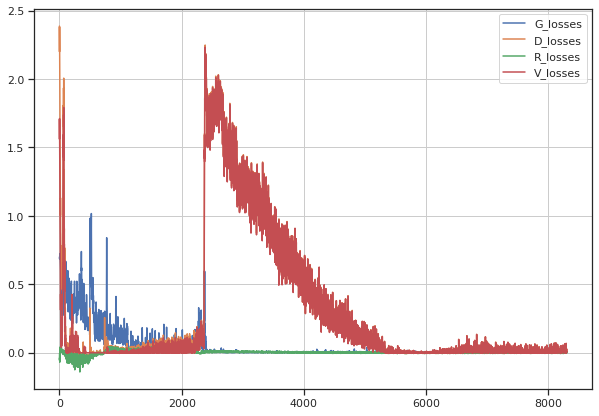

In [44]:
plt.figure(figsize=(10, 7))
plt.plot(losses_pcf[0], label = 'G_losses')
plt.plot(losses_pcf[1], label = 'D_losses')
plt.plot(losses_pcf[2], label = 'R_losses')
plt.plot(losses_pcf[3], label = 'V_losses')
plt.legend()
plt.grid()
plt.show()

### eucledian_distance

In [45]:
losses_ed = train(loader = train_loader, 
                  gen = gen_ed, 
                  disc = disc_ed, 
                  criterion_gan = criterion_gan_ed, 
                  G_opt = G_opt_ed, 
                  D_opt = D_opt_ed, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Eucledian_distance_loss,
                  save_PATH = 'trained_models/gan_ed.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/100] Batch 82/83 Loss D: 0.4056, Loss G: 0.1762, Loss V: 0.0000, Loss R: 0.2944
Epoch [10/100] Batch 82/83 Loss D: 0.3274, Loss G: 0.0514, Loss V: 0.0000, Loss R: 0.3265
Epoch [20/100] Batch 82/83 Loss D: 0.3559, Loss G: 0.0155, Loss V: 0.0000, Loss R: 0.3557
Epoch [30/100] Batch 82/83 Loss D: 0.3264, Loss G: 0.0029, Loss V: 0.0247, Loss R: 0.3016
Epoch [40/100] Batch 82/83 Loss D: 0.2954, Loss G: 0.0056, Loss V: 0.0013, Loss R: 0.2939
Epoch [50/100] Batch 82/83 Loss D: 0.3228, Loss G: 0.0005, Loss V: 0.0194, Loss R: 0.3034
Epoch [60/100] Batch 82/83 Loss D: 0.3355, Loss G: 0.0012, Loss V: 0.0000, Loss R: 0.3355
Epoch [70/100] Batch 82/83 Loss D: 0.4007, Loss G: 0.0003, Loss V: 0.0000, Loss R: 0.4007
Epoch [80/100] Batch 82/83 Loss D: 0.3094, Loss G: 0.0005, Loss V: 0.0000, Loss R: 0.3094
Epoch [90/100] Batch 82/83 Loss D: 0.3284, Loss G: 0.0003, Loss V: 0.0000, Loss R: 0.3284


In [46]:
gen_ed = Generator().to(device)
disc_ed = Discriminator().to(device)

checkpoint_ed = torch.load('trained_models/gan_ed.pt')

gen_ed.load_state_dict(checkpoint_ed['gen_state_dict'])
disc_ed.load_state_dict(checkpoint_ed['disc_state_dict'])
de_ident_rate_ed = checkpoint_ed['de_ident_rate']
str_simil_ed = checkpoint_ed['str_simil']

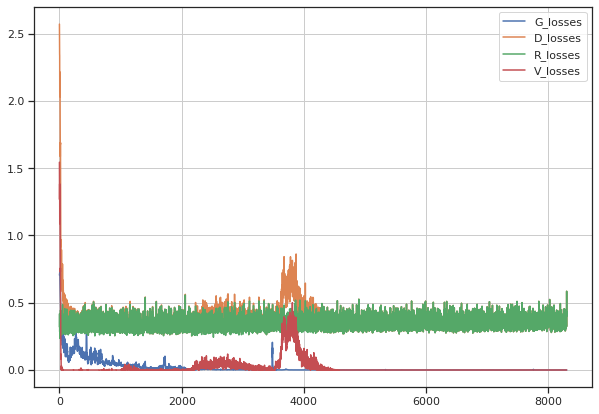

In [47]:
plt.figure(figsize=(10, 7))
plt.plot(losses_ed[0], label = 'G_losses')
plt.plot(losses_ed[1], label = 'D_losses')
plt.plot(losses_ed[2], label = 'R_losses')
plt.plot(losses_ed[3], label = 'V_losses')
plt.legend()
plt.grid()
plt.show()

### ssim

In [48]:
losses_ssim = train(loader = train_loader, 
                    gen = gen_ssim, 
                    disc = disc_ssim, 
                    criterion_gan = criterion_gan_ssim, 
                    G_opt = G_opt_ssim, 
                    D_opt = D_opt_ssim, 
                    model_verification = model_verification, 
                    criterion_verification = criterion_verification, 
                    criterion_regulator = SSIM_1d_conv,
                    save_PATH = 'trained_models/gan_ssim.pt', 
                    lr = lr, 
                    batch_size = batch_size, 
                    num_epochs = num_epochs, 
                    n_noise = n_noise, 
                    n_critic = n_critic)

Epoch [0/100] Batch 82/83 Loss D: 1.8005, Loss G: 0.7357, Loss V: 1.3402, Loss R: 0.3840
Epoch [10/100] Batch 82/83 Loss D: 0.6310, Loss G: 0.0294, Loss V: 0.1418, Loss R: 0.4883
Epoch [20/100] Batch 82/83 Loss D: 0.3864, Loss G: 0.0355, Loss V: 0.0288, Loss R: 0.3574
Epoch [30/100] Batch 82/83 Loss D: 0.3160, Loss G: 0.0185, Loss V: 0.0012, Loss R: 0.3146
Epoch [40/100] Batch 82/83 Loss D: 1.0433, Loss G: 0.0040, Loss V: 0.0000, Loss R: 1.0432
Epoch [50/100] Batch 82/83 Loss D: 0.7768, Loss G: 0.0017, Loss V: 0.0000, Loss R: 0.7767
Epoch [60/100] Batch 82/83 Loss D: 8.1043, Loss G: 0.0034, Loss V: 0.0000, Loss R: 8.1042
Epoch [70/100] Batch 82/83 Loss D: 0.1280, Loss G: 0.0046, Loss V: 0.0000, Loss R: 0.1280
Epoch [80/100] Batch 82/83 Loss D: 0.4945, Loss G: 0.0004, Loss V: 0.0000, Loss R: 0.4945
Epoch [90/100] Batch 82/83 Loss D: 0.3355, Loss G: 0.0006, Loss V: 0.0000, Loss R: 0.3355


In [53]:
gen_ssim = Generator().to(device)
disc_ssim = Discriminator().to(device)

checkpoint_ssim = torch.load('trained_models/gan_ssim.pt')

gen_ssim.load_state_dict(checkpoint_ssim['gen_state_dict'])
disc_ssim.load_state_dict(checkpoint_ssim['disc_state_dict'])
de_ident_rate_ssim = checkpoint_ssim['de_ident_rate']
str_simil_ssim = checkpoint_ssim['str_simil']

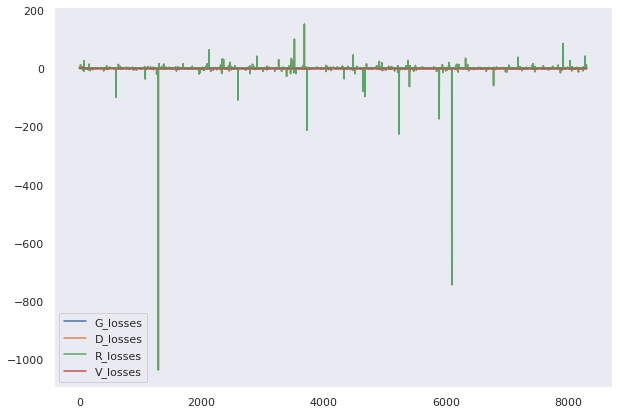

In [54]:
plt.figure(figsize=(10, 7))
plt.plot(losses_ssim[0], label = 'G_losses')
plt.plot(losses_ssim[1], label = 'D_losses')
plt.plot(losses_ssim[2], label = 'R_losses')
plt.plot(losses_ssim[3], label = 'V_losses')
plt.legend()
plt.grid()
plt.show()

### Figure

In [55]:
reg_names = ['Mean_similarity_loss', 
             'Root_mean_square_similarity_loss', 
             'Coisine_between_angles_loss', 
             'Pearson_corr_funct_loss', 
             'Eucledian_distance_loss', 
             'SSIM_1d_conv']

regul_loss_dict = dict.fromkeys(reg_names, [])
regul_loss_list = [Mean_similarity_loss, 
                   Root_mean_square_similarity_loss, 
                   Coisine_between_angles_loss,
                   Pearson_corr_funct_loss, 
                   Eucledian_distance_loss, 
                   SSIM_1d_conv]


In [58]:
de_ident_rate_ms

tensor(1., device='cuda:1')

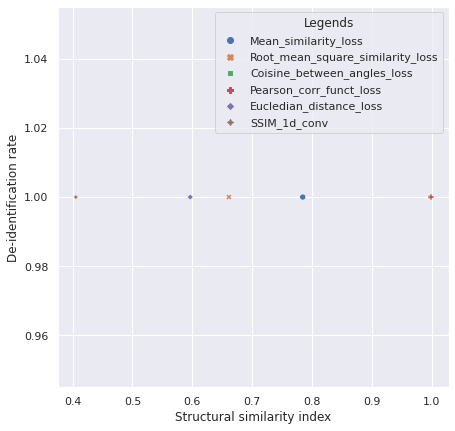

In [59]:
sns.set_theme()
data = pd.DataFrame({
    'Structural similarity index': [str_simil_ms, 
                                    str_simil_rms, 
                                    str_simil_cba, 
                                    str_simil_pcf, 
                                    str_simil_ed, 
                                    str_simil_ssim],
    'De-identification rate': [de_ident_rate_ms.cpu(), 
                               de_ident_rate_rms.cpu(), 
                               de_ident_rate_cba.cpu(), 
                               de_ident_rate_pcf.cpu(), 
                               de_ident_rate_ed.cpu(), 
                               de_ident_rate_ssim.cpu()],
    'Legends': reg_names})

plt.figure(figsize = (7, 7))
sns.scatterplot(data=data, x="Structural similarity index", 
                y="De-identification rate", 
                hue = 'Legends', 
                style="Legends",
                legend='brief');
plt.savefig('De_iden_vs_structural_simil')


## test

In [60]:
scales_vectors = np.array([torch_dataset.feature_scales[f] for f in range(len(required_params))])

sparse_rate = torch_dataset.sparse_rate
print('sparse_rate', sparse_rate)
L = 64
print('L', L)
# window = L * sparse_rate
window = 64
print('window', window)
step = 4
print('step', step)

sparse_rate 1
L 64
window 64
step 4


In [61]:
test_well = wells[22]
test_well

'well_17.json'

In [62]:
X_test = pd.DataFrame(logs[22]['data'], columns=[x['name'] for x in logs[22]['curves']])
X_test = X_test[required_params]
X_test = X_test.drop_duplicates()

In [63]:
y_name = 'DEPTH'
# X_test

In [64]:
def apply_window_transform(x, s, latent_noise_rate=0):
    x = x[np.arange(0, len(x), sparse_rate), :]
    mean_x = x.mean(axis=0)
    x = (x - mean_x)/s
    with torch.no_grad():
        x = torch.Tensor(x).view(1, x.shape[0], -1).to(device)
        z = gen_ssim(x.transpose(1, 2))
    
    return z.transpose(1, 2)[0].cpu().data.numpy()*s + mean_x, z.transpose(1, 2)[0].cpu().data.numpy()

In [65]:
def apply_rolling_transform(X, w, scales, step=12):
    Z = []
    
    for i in tqdm(range(0, len(X) - w, step)):
        Z.append(apply_window_transform(X[i: i+w], scales))
        
    return Z

In [66]:
Z = apply_rolling_transform(X_test[required_params].values, window, scales_vectors, step)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:03<00:00, 276.22it/s]


837it [00:00, 184731.24it/s]
/tmp/ipykernel_6310/717006292.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 194129.20it/s]
/tmp/ipykernel_6310/717006292.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 184459.46it/s]
/tmp/ipykernel_6310/717006292.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 182247.44it/s]
/tmp/ipykernel_6310/717006292.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
837it [00:00, 189835.75it/s]
/tmp/ipykernel_6310/717006292.py:16: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)


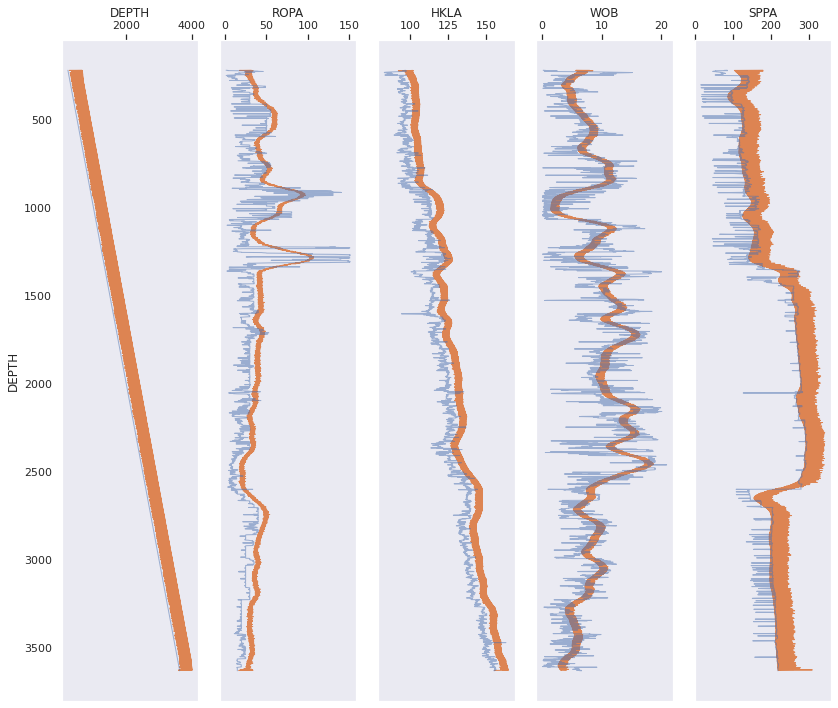

In [68]:
original = []
generated = []

t = X_test[y_name].astype(float).values
plt.figure(figsize=(14, 10))
for i, curve_name in enumerate(required_params):
    plt.subplot(1, len(df.columns) - 1, i + 1)
#     for zi, x in tqdm(enumerate(range(0, len(df_well) - window, step))):
#         plt.plot(Z[zi][0][:, i], t[np.arange(x, x+window, sparse_rate)], color='C1', alpha=0.5, lw=0.5)

    zis = range(0, len(X_test) - window, step)
    A = np.zeros((len(zis), len(X_test))) * np.nan
    for zi, x in tqdm(enumerate(zis)):
        A[zi, np.arange(x, x+window, sparse_rate)] = Z[zi][0][:, i]
    
    A = np.nanmean(A, axis=0)
    not_nan_inds = np.where(~np.isnan(A))[0]
    
    original.append(X_test[curve_name].astype(float).values)
    generated.append(A[not_nan_inds])
    
    plt.plot(A[not_nan_inds], t[not_nan_inds], color='C1', lw=1)
    plt.plot(X_test[curve_name].astype(float).values, t, lw=1, color='C0', alpha=0.5)
    plt.grid()
    axis = plt.gca()
    axis.invert_yaxis()
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top')
    if i > 0: axis.set_yticklabels([])

    if i == 0:
        plt.ylabel(f'{y_name}')
    plt.xlabel(f'{curve_name}')

plt.tight_layout()
# plt.save('')

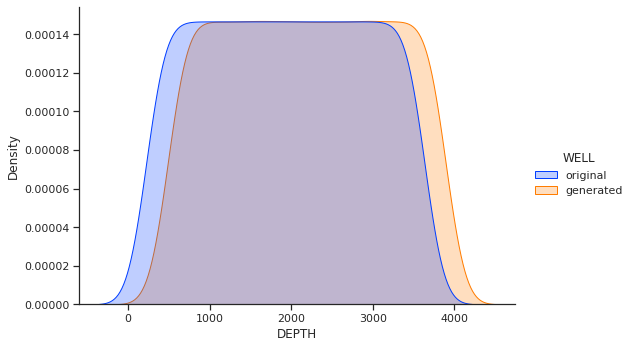

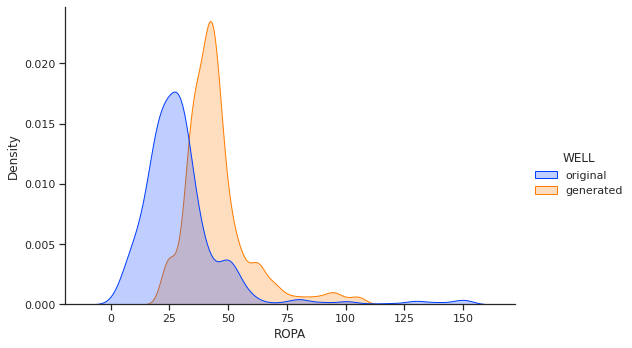

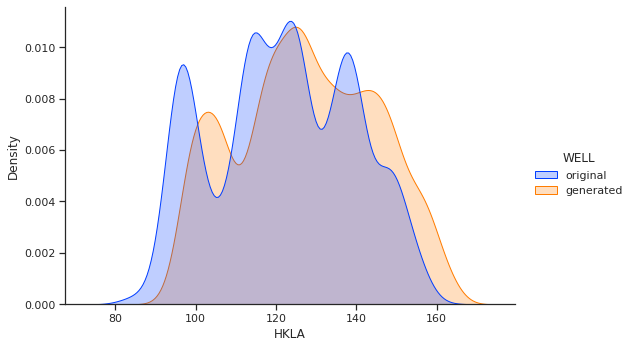

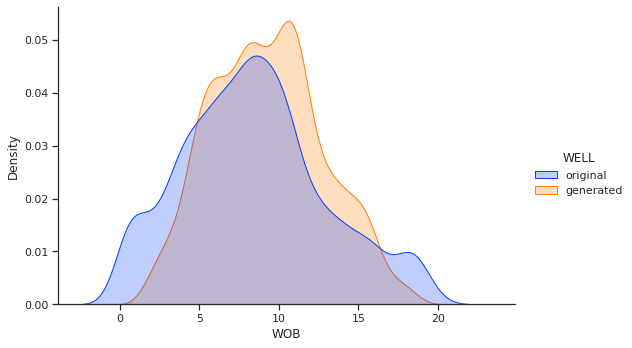

In [58]:
for i in required_params[:-1]:
    sns.displot(data=df_some, 
            x=i, hue='WELL', kind='kde',
            fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5
               )